# Evaluation methods and Data reading

* Using prequential, test-then-train and windowed evaluation. 
* We show how using either CSV or ARFF the API works.
* The CSV reader infer the task (classification or regression), but one can force the task to be interpreted as regression.

**Notebook last update: 08/12/2023**

In [1]:
from capymoa.evaluation import windowed_evaluation, prequential_evaluation, test_then_train_evaluation, prequential_evaluation_multiple_learners

capymoa_root: /home/antonlee/github.com/tachyonicClock/MOABridge/src/capymoa
MOA jar path location (config.ini): /home/antonlee/github.com/tachyonicClock/MOABridge/src/capymoa/jar/moa.jar
JVM Location (system): 
JAVA_HOME: /usr/lib/jvm/java-17-openjdk
JVM args: ['-Xmx8g', '-Xss10M']


Sucessfully started the JVM and added MOA jar to the class path


## File paths

In [2]:
# Classification
arff_elec_path = '../data/electricity.arff'
csv_elec_path = '../data/electricity.csv'
# Stream with 100k instances
rbf_path = '../data/RBFm_100k.arff'
# Stream with 580k instances and around 100 features (csv)
covtfd_csv_file_path = '../data/covtFD.csv'
# Regression
csv_fried_path = '../data/fried.csv'

## Classification evaluation

### Reading a stream from a CSV file and using one learner
* Uses the ClassificationWindowedEvaluator directly

In [3]:
from capymoa.evaluation import ClassificationWindowedEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.classifier import AdaptiveRandomForest

stream = stream_from_file(path_to_csv_or_arff=csv_elec_path)
ARF = AdaptiveRandomForest(schema=stream.get_schema(), CLI="-s 5 -x (ADWINChangeDetector -a 0.001) -p (ADWINChangeDetector -a 0.01)")
evaluator = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)

while stream.has_more_instances():
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    evaluator.update(instance.y_index, prediction)
    ARF.train(instance)

display(evaluator.metrics_per_window())

,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent),F1 Score (percent),F1 Score for class 0 (percent),F1 Score for class 1 (percent),Precision (percent),Precision for class 0 (percent),Precision for class 1 (percent),Recall (percent),Recall for class 0 (percent),Recall for class 1 (percent)
0,4500.0,88.355556,75.503335,27.922971,70.328426,87.758315,90.472727,85.028571,87.915528,89.819495,86.011561,87.601664,91.135531,84.067797
1,9000.0,86.311111,72.447892,18.410596,70.212766,86.224076,87.319885,85.127958,86.216343,87.427865,85.004822,86.231811,87.212171,85.251451
2,13500.0,88.355556,76.702644,20.726172,75.627907,88.370989,88.638335,88.058341,88.340412,90.044053,86.636771,88.401586,87.275833,89.527340
3,18000.0,86.355556,71.799141,5.246914,67.461579,85.929087,88.445615,83.342377,86.192790,87.004813,85.380767,85.666993,89.934941,81.399046
4,22500.0,86.844444,71.739671,17.548747,66.420874,86.090562,89.621318,82.038835,87.170355,86.147624,88.193085,85.037192,93.386920,76.687465
5,27000.0,84.955556,68.435024,-18.356643,63.796791,84.441315,87.697619,80.640549,85.325715,83.988862,86.662569,83.575059,91.749049,75.401070
6,31500.0,84.755556,67.490884,-25.182482,60.867085,83.816605,87.815275,79.643917,84.368607,85.744017,82.993197,83.271779,89.989079,76.554478
7,36000.0,84.200000,67.055826,-19.495798,60.478043,83.528091,86.855241,80.200501,83.550063,86.742984,80.357143,83.506129,86.967790,80.044469
8,40500.0,85.444444,70.466772,1.799100,66.427473,85.245057,87.006546,83.455418,85.136261,88.001605,82.270916,85.354132,86.033739,84.674526
9,45000.0,87.911111,75.530434,22.285714,75.539568,87.813316,89.128697,86.386386,88.027464,87.177482,88.877446,87.600207,91.169256,84.031159


### Reading from an ARFF file and using 2 learners
* Uses the ClassificationEvaluator, thus it uses a cumulative approach for calculating the metrics (not windowed)

In [4]:
from capymoa.evaluation import ClassificationEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.classifier import OnlineBagging, AdaptiveRandomForest

stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)
OB_learner = OnlineBagging(schema=stream.get_schema(), ensemble_size=5)
ARF_learner = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=5)

# Not a windowed evaluator!
OB_evaluator = ClassificationEvaluator(schema=stream.get_schema())
ARF_evaluator = ClassificationEvaluator(schema=stream.get_schema())

while stream.has_more_instances():
    instance = stream.next_instance()
    
    OB_prediction = OB_learner.predict(instance)
    ARF_prediction = ARF_learner.predict(instance)
    
    OB_evaluator.update(instance.y_index, OB_prediction)
    ARF_evaluator.update(instance.y_index, ARF_prediction)

    OB_learner.train(instance)
    ARF_learner.train(instance)

print(f"OB final accuracy = {OB_evaluator.accuracy()} and ARF final accuracy = {ARF_evaluator.accuracy()}")

OB final accuracy = 79.05190677966102 and ARF final accuracy = 86.36564265536724


### Reading the data from a CSV, then evaluating it using two learners. 
* **Using the ```prequential_evaluation``` which internally executes both ```ClassificationWindowedEvaluator``` and ```ClassificationEvaluator```**
* ```prequential_evaluation``` allow us to have the windowed and cumulative results. So we can inspect the last accuracy and over time too. 
* We also plot the final results using ```plot_windowed_results```

OnlineBagging final accuracy = 78.65686793785311 and     AdaptiveRandomForest  final accuracy = 85.24231991525424


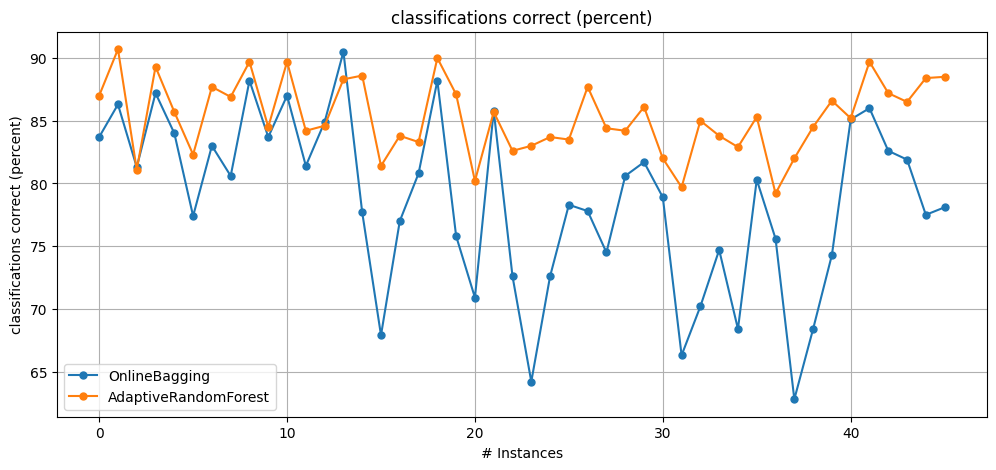

In [5]:
from capymoa.evaluation.visualization import plot_windowed_results

from capymoa.evaluation import ClassificationWindowedEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.classifier import OnlineBagging, AdaptiveRandomForest

stream = stream_from_file(path_to_csv_or_arff=csv_elec_path)
OB_learner = OnlineBagging(schema=stream.get_schema(), ensemble_size=2)
ARF_learner = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=2)

OB_results = prequential_evaluation(stream=stream, learner=OB_learner, window_size=1000)
stream.restart()
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=1000)

print(f"{OB_results['learner']} final accuracy = {OB_results['cumulative'].accuracy()} and \
    {ARF_results['learner']}  final accuracy = {ARF_results['cumulative'].accuracy()}")

plot_windowed_results(OB_results, ARF_results)

### Simple test-then-train evaluation (cumulative). 

In [6]:
stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)

l = OnlineBagging(schema=stream.get_schema(), ensemble_size=2)

res = test_then_train_evaluation(stream, l)
print(res['cumulative'].accuracy())
print(res)

78.65686793785311
{'learner': 'OnlineBagging', 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator object at 0x7f47c3da5650>, 'wallclock': 0.4540889263153076, 'cpu_time': 0.4009213349999996, 'max_instances': -1, 'stream': <capymoa.stream.stream.ARFFStream object at 0x7f47c34943d0>}


### Simple windowed evaluation

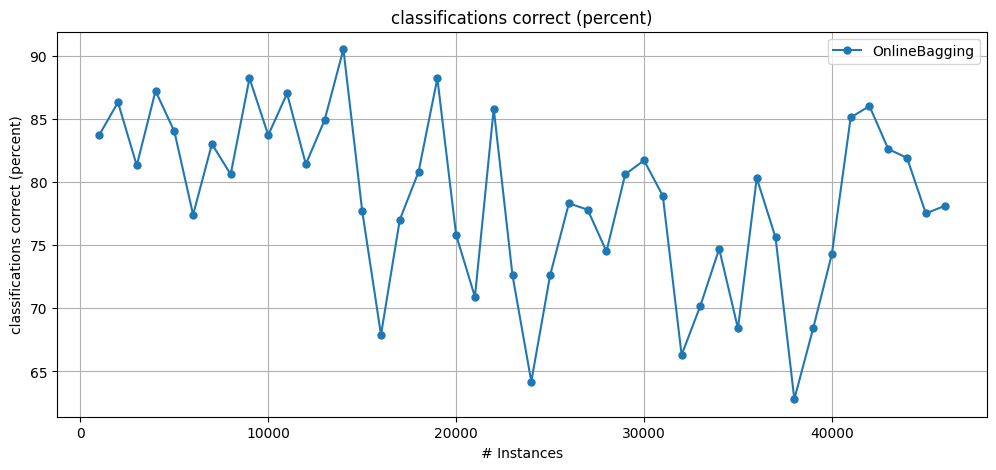

In [7]:
stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)

l = OnlineBagging(schema=stream.get_schema(), ensemble_size=2)

res = windowed_evaluation(stream, l)
plot_windowed_results(res)

### Prequential evaluation, single stream, multiple learners. 
* Important: the ```prequential_evaluation_multiple_learners``` iterate through the stream testing and training with each learner
* This method does not calculate ```wallclock``` or ```cpu_time``` because the training and testing of each learner is interleaved

OB final accuracy = 78.65686793785311 and ARF final accuracy = 85.24231991525424


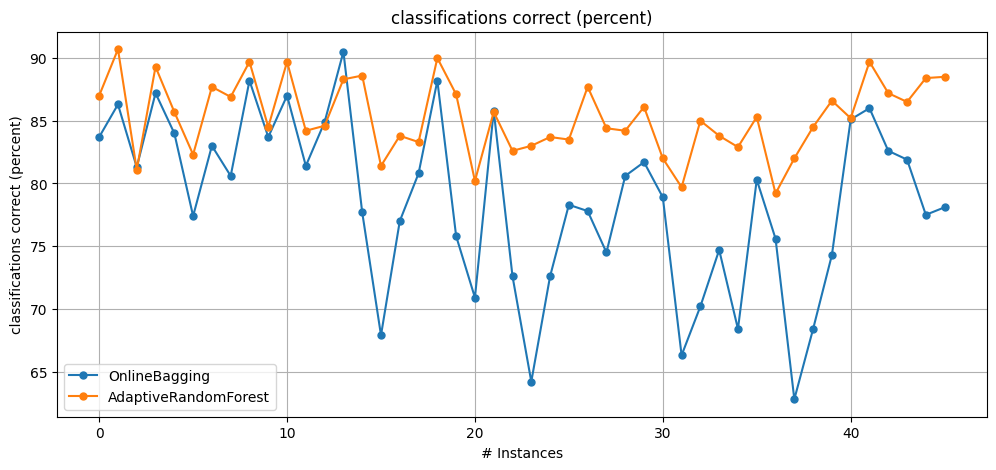

In [8]:
stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)

# Define the learners + an alias (dictionary key)
learners = {
    'OB': OnlineBagging(schema=stream.get_schema(), ensemble_size=2),
    'ARF': AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=2)
}

results = prequential_evaluation_multiple_learners(stream, learners)

print(f"OB final accuracy = {results['OB']['cumulative'].accuracy()} and ARF final accuracy = {results['ARF']['cumulative'].accuracy()}")
plot_windowed_results(results['OB'], results['ARF'], metric="classifications correct (percent)")

### prequential_evaluation with a larger stream (100k instances)

{'learner': 'OnlineBagging',
 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator at 0x7f47c1cef4d0>,
 'windowed': <capymoa.evaluation.evaluation.ClassificationWindowedEvaluator at 0x7f47c1cde890>,
 'wallclock': 7.812121868133545,
 'cpu_time': 4.39874992,
 'max_instances': -1,
 'stream': <capymoa.datasets.datasets.RBFm_100k at 0x7f47c1cd0090>}

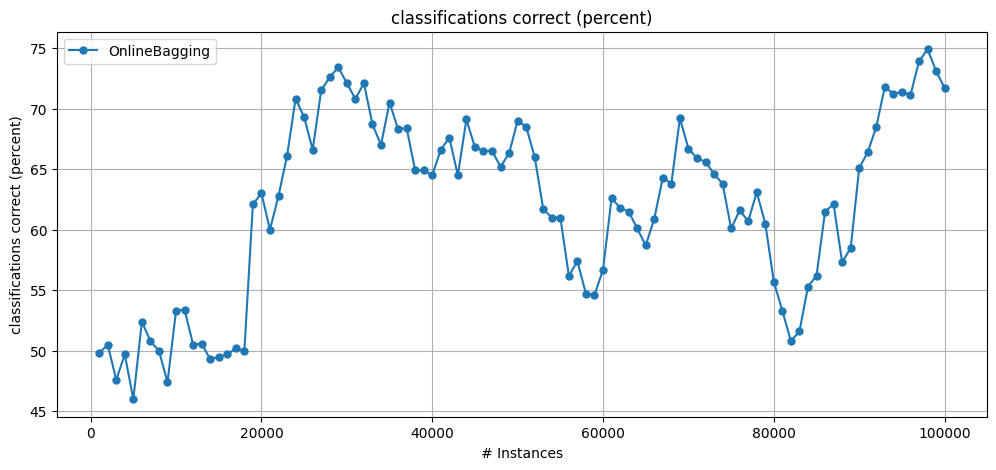

In [9]:
from capymoa.datasets import RBFm_100k

stream = RBFm_100k()
l = OnlineBagging(schema=stream.get_schema(), ensemble_size=10)

res = prequential_evaluation(stream, l, window_size=1000)
display(res)
plot_windowed_results(res)

### Reading the data from a large CSV
* Using the covtFD.csv file with more than 580k instances and 100 features


In [ ]:
%%time
# TODO: This csv file is no longer downloaded by default. This should be fixed
# in the future.
from capymoa.stream import stream_from_file

# Loads the csv data to memory, it should take from 1 minute to 2 minutes. 
stream = stream_from_file(path_to_csv_or_arff=covtfd_csv_file_path, class_index=-1)

In [ ]:
# TODO: See above
from capymoa.learner import MOAClassifier
from capymoa.evaluation import test_then_train_evaluation
from moa.classifiers.bayes import NaiveBayes

learner = MOAClassifier(moa_learner=NaiveBayes())

stream.restart()

results = test_then_train_evaluation(stream=stream, learner=learner, max_instances=None, sample_frequency=None)

display(results)
display(results['cumulative'].metrics_per_window())
print(results['cumulative'].accuracy())

## Regression evaluation

###  Reading a stream from a CSV file and using one learner
* Uses the ```RegressionWindowedEvaluator``` directly

In [10]:
from capymoa.evaluation import RegressionWindowedEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.regressor import AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
ARF = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)


evaluator = RegressionWindowedEvaluator(schema=stream.get_schema(), window_size=5000)

while stream.has_more_instances():
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    evaluator.update(instance.y_value, prediction)
    ARF.train(instance)

display(evaluator.metrics_per_window())

,classified instances,mean absolute error,root mean squared error,relative mean absolute error,relative root mean squared error,coefficient of determination,adjusted coefficient of determination
0,5000.0,3.301312,4.212785,0.826254,0.855881,0.267467,0.265852
1,5000.0,2.981176,3.867996,0.727015,0.767106,0.411548,0.410250
2,5000.0,2.828599,3.704090,0.696853,0.740711,0.451348,0.450138
3,5000.0,2.812868,3.685687,0.690389,0.733612,0.461814,0.460627
4,5000.0,2.802291,3.656377,0.695275,0.734827,0.460029,0.458838
5,5000.0,2.742057,3.593869,0.683031,0.726970,0.471515,0.470349
6,5000.0,2.766988,3.633832,0.662587,0.709115,0.497156,0.496047
7,5000.0,2.708092,3.537754,0.664940,0.707693,0.499170,0.498066


### Reading from an ARFF file and using 2 learners
* Uses the RegressionEvaluator, thus it uses a cumulative approach for calculating the metrics (not windowed)

In [11]:
from capymoa.evaluation import RegressionEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)

# Not a windowed evaluator!
kNN_evaluator = RegressionEvaluator(schema=stream.get_schema())
ARF_evaluator = RegressionEvaluator(schema=stream.get_schema())

while stream.has_more_instances():
    instance = stream.next_instance()
    
    kNN_prediction = kNN_learner.predict(instance)
    ARF_prediction = ARF_learner.predict(instance)
    
    kNN_evaluator.update(instance.y_value, kNN_prediction)
    ARF_evaluator.update(instance.y_value, ARF_prediction)

    kNN_learner.train(instance)
    ARF_learner.train(instance)

print(f"OB final MAE = {kNN_evaluator.MAE()} and ARF final MAE = {ARF_evaluator.MAE()}")

OB final MAE = 2.171382783882719 and ARF final MAE = 2.864632534308498


### Reading the data from a CSV, then evaluating it using two learners. 
* **Using the ```prequential_evaluation``` which internally executes both ```RegressionWindowedEvaluator``` and ```RegressionEvaluator```**
* ```prequential_evaluation``` allow us to have the windowed and cumulative results. So we can inspect the last accuracy and over time too. 
* We also plot the final results using ```plot_windowed_results```

kNNRegressor final RMSE = 2.7394543131282583 and     AdaptiveRandomForestRegressor  final accuracy = 3.303185689295369


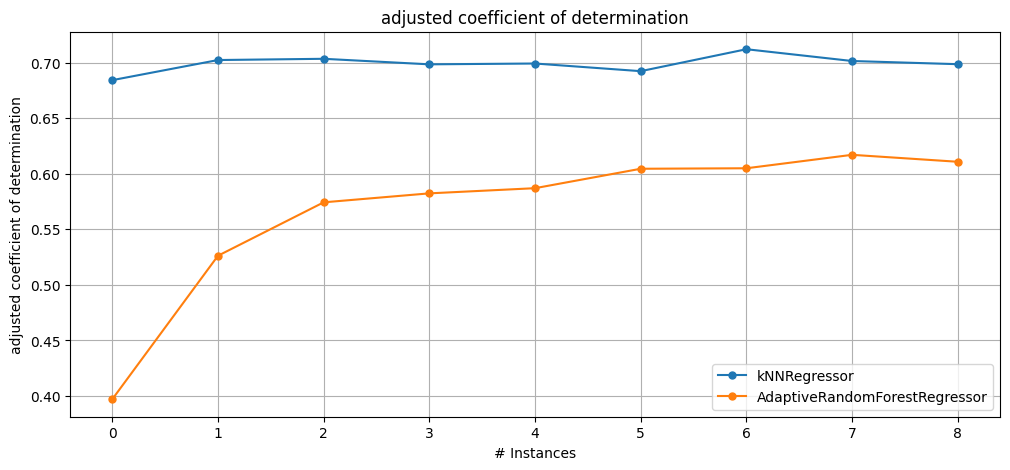

In [12]:
from capymoa.evaluation.visualization import plot_windowed_results

from capymoa.evaluation import prequential_evaluation
from capymoa.stream import stream_from_file

from capymoa.learner.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)

kNN_results = prequential_evaluation(stream=stream, learner=kNN_learner, window_size=5000)
stream.restart()
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000)

print(f"{kNN_results['learner']} final RMSE = {kNN_results['cumulative'].RMSE()} and \
    {ARF_results['learner']}  final accuracy = {ARF_results['cumulative'].RMSE()}")

plot_windowed_results(kNN_results, ARF_results, metric='adjusted coefficient of determination')

### Simple test-then-train evaluation (cumulative). 

In [13]:
stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)

kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)

res = test_then_train_evaluation(stream, kNN_learner)
print(res['cumulative'].MAE())
print(res)

2.171382783882719
{'learner': 'kNNRegressor', 'cumulative': <capymoa.evaluation.evaluation.RegressionEvaluator object at 0x7f48b81573d0>, 'wallclock': 10.1120023727417, 'cpu_time': 5.936483706000004, 'max_instances': None, 'stream': <capymoa.stream.stream.NumpyStream object at 0x7f47c1c86e10>}


### Prequential evaluation, single stream, multiple learners. 
* Important: the ```prequential_evaluation_multiple_learners``` iterate through the stream testing and training with each learner
* This method does not calculate ```wallclock``` or ```cpu_time``` because the training and testing of each learner is interleaved

kNNReg_k5: {'classified instances': 40768.0, 'mean absolute error': 2.171382783882719, 'root mean squared error': 2.7394543131282583, 'relative mean absolute error': 0.5343076205436615, 'relative root mean squared error': 0.5474215436522585, 'coefficient of determination': 0.7003296535453785, 'adjusted coefficient of determination': 0.7002487728453343} 

kNNReg_k2: {'classified instances': 40768.0, 'mean absolute error': 2.455209968602826, 'root mean squared error': 3.101880727919028, 'relative mean absolute error': 0.6041483823103337, 'relative root mean squared error': 0.6198447362911451, 'coefficient of determination': 0.6157925028921607, 'adjusted coefficient of determination': 0.6156888057072509} 

kNNReg_k5_median: {'classified instances': 40768.0, 'mean absolute error': 2.3265919348508635, 'root mean squared error': 2.95901097128398, 'relative mean absolute error': 0.5724996117282386, 'relative root mean squared error': 0.5912952611845242, 'coefficient of determination': 0.65036

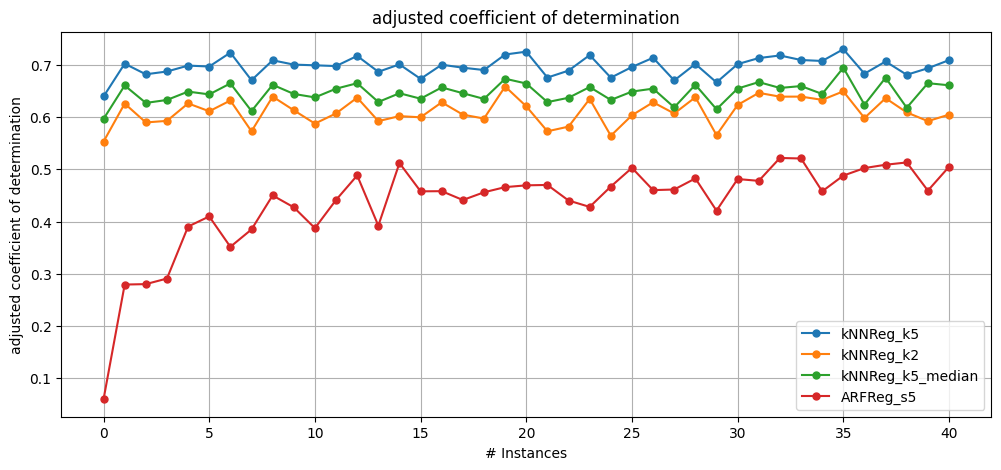

In [14]:
stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)

# Define the learners + an alias (dictionary key)
learners = {
    'kNNReg_k5': KNNRegressor(schema=stream.get_schema(), k=5),
    'kNNReg_k2': KNNRegressor(schema=stream.get_schema(), k=2),
    'kNNReg_k5_median': KNNRegressor(schema=stream.get_schema(), CLI='-k 5 -m'),
    'ARFReg_s5': AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)
}

results = prequential_evaluation_multiple_learners(stream, learners)

for learner_id in results.keys():
    print(f"{learner_id}: {results[learner_id]['cumulative']} \n")
    results[learner_id]['learner']=learner_id # sets the identifiers correctly for plotting

plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s5'], metric="adjusted coefficient of determination")